## Failure analysis example

Let's consider a fixed-wing glider with simplified flat-plate dynamics restricted to the $xz$ plane. The state of the system is position, orientation of the glider body, elevator angle $\phi$, and spatial velocity.

$$x = [x, z, \theta, \phi, f_{thrust}, v_x, v_z, \dot{\theta}]^T$$

and control inputs for the desired rate of change of the elevator angle $u = [\dot{\phi}, \dot{f_{thrust}}]$. These dynamics are based on the glider dynamics from [this notebook](https://deepnote.com/workspace/Underactuated-2ed1518a-973b-4145-bd62-1768b49956a8/project/System-Identification-for-the-Perching-Glider-d326e0f0-cd2d-4184-9308-0496512308fc/notebook/glider_sysid-f861b6e776ce4aa2b1bb62257373947f), with an added thrust.

In [1]:
using Plots
using Gen
using LinearAlgebra
using Printf
using DelimitedFiles
using Random

In [2]:
# Global physical parameters
m = 0.08 # body mass.
Sw = 0.0885 # surface area of wing + fuselage + tail.
Se = 0.0147 # surface area of elevator.
I = 0.0015 # body inertia.
lw = 0 # horizontal offset of wing center.
le = 0.022 # elevator aerodynamic center from hinge.
lh = 0.27 # elevator hinge.
thrust_damping = 10.0
rho = 1.204 # air density (kg/m^3).
g = 9.81; # gravity.

In [3]:
function plate_aero_force(
        cop_velocity::Vector{Float64},
        normal::Vector{Float64},
        surface_area::Float64,
    )
    """
    Compute the force acting on a flat plate.
    
    args:
        cop_velocity: [x, z] velocity of the center of pressure of the plate (m/s)
        cop_velocity: [x, z] unit normal to the plate
        surface_area: surace area of the plate (m^2)
        rho: density of air (kg/m^3)
    returns:
        [fx, fz] force on the plate
    """
    speed = sqrt(sum(cop_velocity .^ 2))
    force = -rho * surface_area * (transpose(normal) * cop_velocity) * speed
    return force
end;

function get_forces_on_glider(
        state::Vector{Float64},
        u::Vector{Float64},
    )
    
    """
    Compute the forces acting on the glider.
    
    args:
        state: [x, z, theta, phi, vx, vz, theta_dot]
        u: [phi_dot] control input
    """
    x, z, theta, phi, f_thrust, vx, vz, theta_dot = state
    
    # Get forces on the wing
    v_wing = [
        vx + lw * theta_dot * sin(theta),
        vz + lw * theta_dot * cos(theta)
    ]
    n_wing = [sin(theta), cos(theta)]
    f_wing = plate_aero_force(v_wing, n_wing, Sw)
    
    # Get forces on the elevator
    elevator_angle = theta + phi
    elevator_angle_dot = theta_dot + u[1]
    v_elevator = [
        vx + lh * theta_dot * sin(theta) + le * elevator_angle_dot * sin(elevator_angle),
        vz + lh * theta_dot * cos(theta) + le * elevator_angle_dot * cos(elevator_angle),
    ]
    n_elevator = [sin(elevator_angle), cos(elevator_angle)]
    f_elevator = plate_aero_force(v_elevator, n_elevator, Se)
    
    return f_wing, f_elevator
end;

function next_state(
        state::Vector{Float64},
        u::Vector{Float64},
        dt::Float64,
        disturbance::Vector{Float64},
    )
    
    """
    Compute the next state of the glider
    
    args:
        state: [x, z, theta, phi, f_thrust, vx, vz, theta_dot]
        u: [phi_dot] control input
        dt: timestep for integration
        disturbance: [fx, fz, tau] disturbance wrench
    """
    x, z, theta, phi, f_thrust, vx, vz, theta_dot = state
    state_dot = fill(0.0, size(state))
    
    # Positions update via velocities
    state_dot[1:3] = state[6:end]
    state_dot[4] = u[1]
    
    # Thrust changes based on control input with some damping
    state_dot[5] = u[2] - thrust_damping * f_thrust
    
    # Get accelerations
    f_wing, f_elevator = get_forces_on_glider(state, u)
    a_x = 1 / m * (
        f_wing * sin(theta) + f_elevator * sin(theta + phi)
        + f_thrust * cos(theta)
        + disturbance[1]
    )
    a_z = -g + 1 / m * (
        f_wing * cos(theta) + f_elevator * cos(theta + phi)
        - f_thrust * sin(theta)
        + disturbance[2]
    )
    theta_ddot = 1 / I * (
        f_wing * lw + f_elevator * (lh * cos(phi) + le)
        + disturbance[3]
    )
    
    state_dot[6] = a_x
    state_dot[7] = a_z
    state_dot[8] = theta_ddot
    
    next_state = state .+ dt * state_dot
    
    # Enforce limits on elevator angle and thrust
    next_state[4] = clamp(next_state[4], -pi / 3, pi / 3)
    next_state[5] = clamp(next_state[5], 0.0, 10.0)
    
    return next_state
end;

function next_state_substepped(
        state::Vector{Float64},
        u::Vector{Float64},
        dt::Float64,
        substeps::Int,
        disturbance::Vector{Float64},
    )
    
    """
    Compute the next state of the glider using multiple substeps
    
    args:
        state: [x, z, theta, phi, f_thrust, vx, vz, theta_dot]
        u: [phi_dot] control input
        dt: timestep for integration
        substeps: break the integration into this many forward Euler steps
        disturbance: [fx, fz, tau] disturbance wrench
    """
    dt_substep = dt / substeps
    for i=1:substeps
        state = next_state(state, u, dt_substep, disturbance)
    end
    return state
end

function control_policy(state::Vector{Float64})
    """Define a control policy for level flight"""
    x, z, theta, phi, f_thrust, vx, vz, theta_dot = state
    
    # Control elevator angle
    phi_dot = (
        7.0 * theta + 0.7 * theta_dot  # PD stabilization for angle
        - 0.7 * z  # P stabilization for altitude
    )
    
    # Control thrust
    vx_setpoint = 10.0
    throttle = (
        - 5.0 * (vx - vx_setpoint)  # P tracking of downrange velocity
    )
    
    return [phi_dot, throttle]
end;

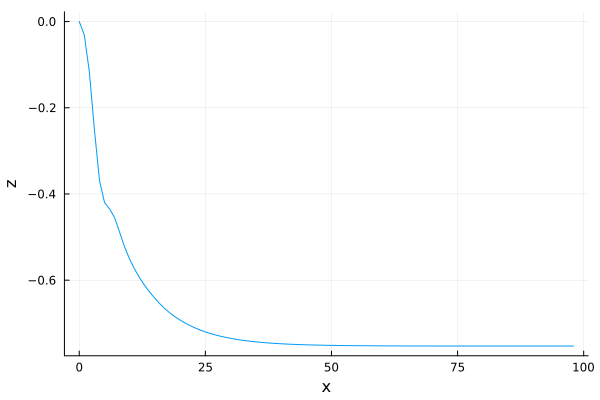

In [4]:
# Let's simulate to see how this model + controller works!
x = [0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0]
d = fill(0.0, 3)  # no disturbance for now
steps = 100
dt = 0.1
substeps = 10
xs = zeros(steps, 8)
xs[1, :] = x
for i in range(2, stop=steps)
    u = control_policy(x)
    x = next_state_substepped(x, u, dt, substeps, d)
    xs[i, :] = x
end

plot(xs[:, 1], xs[:, 2], label=false, xlabel="x", ylabel="z")

In [5]:
# This isn't very interesting, so let's add the possibility
# of failures in the controls
# Now let's wrap this into a generative model for Gen

# Also use the unfold structure
struct State
    x::Vector{Float64}
    throttle_failure::Bool
    elevator_failure::Bool
end

@gen (static) function integration_substep(
        t::Int,
        x::Vector{Float64},
        throttle_failure::Bool,
        elevator_failure::Bool,
        disturbance_force_cov::Matrix{Float64},
        dt::Float64,
    )::Vector{Float64}
    # Evaluate the policy
    u = control_policy(x)
    
    # Apply failures
    throttle_input = throttle_failure ? 0.0 : u[2]
    elevator_input = elevator_failure ? 0.0 : u[1]
    
    # Apply disturbance
    d ~ mvnormal(fill(0, 3), disturbance_force_cov)
    
    # Take a step
    x_next = next_state(x, [elevator_input, throttle_input], dt, d)
    
    return x_next
end

integration_step = Gen.Unfold(integration_substep);

@gen (static) function kernel(
        t::Int,
        state::State,
        throttle_failure_probability::Float64,
        throttle_repair_probability::Float64,
        elevator_failure_probability::Float64,
        elevator_repair_probability::Float64,
        disturbance_force_cov::Matrix{Float64},
        observation_noise_cov::Matrix{Float64},
    )
    x = state.x
    throttle_failure = state.throttle_failure
    elevator_failure = state.elevator_failure

    # Update failure state
    throttle_update_probability = throttle_failure ? 1 - throttle_repair_probability : throttle_failure_probability
    next_throttle_failure = {:throttle_failure} ~ bernoulli(throttle_update_probability)
    
    elevator_update_probability = elevator_failure ? 1 - elevator_repair_probability : elevator_failure_probability
    next_elevator_failure = {:elevator_failure} ~ bernoulli(elevator_update_probability)

    substeps = 10
    dt = 0.1
    x_substeps ~ integration_step(
        substeps,
        x,
        throttle_failure,
        elevator_failure,
        disturbance_force_cov,
        dt / substeps
    )
    x_next = x_substeps[end]
    
    # Make observations about pose
    obs ~ mvnormal(x_next[1:3], observation_noise_cov)
    
    # Save the state as a choice so we can look at it later
    state ~ mvnormal(x_next, diagm(fill(0.00001, 8)))
    
    return State(x_next, next_throttle_failure, next_elevator_failure)
end

chain_fn = Gen.Unfold(kernel);

In [6]:
@gen (static) function flight_model_with_failure(steps::Int)
    # Simulate flight with the defined dynamics model and controller,
    # now with the option for spicy failures!
    
    # args:
    #    timesteps: number of steps to simulate
    # Define the initial state
    initial_state_mean = [0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0]
    initial_state_cov = diagm(fill(0.01, 8))
    x0 ~ mvnormal(initial_state_mean, initial_state_cov)
    
    # Define process and observation noise characteristics
    disturbance_force_cov = diagm(fill(0.0001, 3))
    observation_noise_cov = diagm(fill(0.1, 3))
    obs0 ~ mvnormal(x[1:3], observation_noise_cov)
    
    # Define the failure characteristics
    throttle_failure_probability = 0.01  # whether it fails at each step
    throttle_repair_probability = 0.05  # whether or not it gets fixed at each step
    elevator_failure_probability = 0.01
    elevator_repair_probability = 0.05

    # Simulate
    initial_state = State(x0, false, false)
    chain ~ chain_fn(
        steps,
        initial_state,
        throttle_failure_probability,
        throttle_repair_probability,
        elevator_failure_probability,
        elevator_repair_probability,
        disturbance_force_cov,
        observation_noise_cov,
    )
    
    # Return observations of just the position and angle
    return chain
end;

function render(trace; overlay=false)
    T = Gen.get_args(trace)[1]
    obs = Matrix{Float64}(undef, T, 3)
    for t=1:T
        obs[t, :] = trace[:chain => t => :obs]
    end
    throttle_failure = [trace[:chain => t => :throttle_failure] for t=1:T]
    elevator_failure = [trace[:chain => t => :elevator_failure] for t=1:T]
    
    state = Matrix{Float64}(undef, T, 8)
    for t=1:T
        state[t, :] = trace[:chain => t => :state]
    end
    
    f = overlay ? plot! : plot
    dt = 0.1
    t_range = range(0.0, (T - 1) * dt, step=dt)
    plt = plot(t_range, state[:, 2], xlabel="t", label="z", legend_position=:topleft)
    plot!(t_range, obs[:, 2], xlabel="t", label="z obs", legend_position=:topleft)
    plot!(t_range, state[:, 3], xlabel="t", label="θ", legend_position=:topleft)
    plot!(t_range, obs[:, 3], xlabel="t", label="θ obs", legend_position=:topleft)
    plot!(t_range, throttle_failure, label="throttle failure?")
    plot!(t_range, elevator_failure, label="elevator failure?")

    return plt
end;

Gen.@load_generated_functions # To allow use of the generative function written in the static modeling language above.

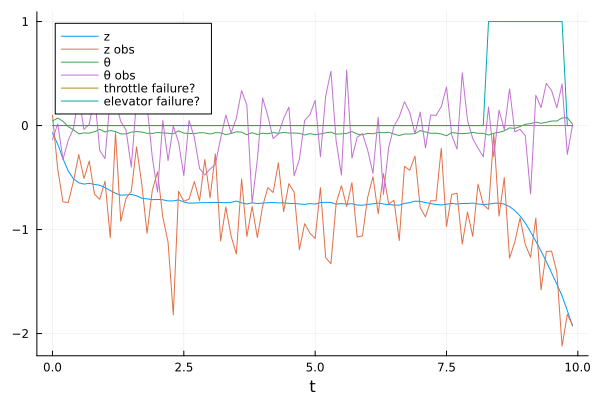

In [7]:
# Now let's simulate that and see what happened
Random.seed!(6)
steps = 100
trace = Gen.simulate(flight_model_with_failure, (steps,))
observed = Matrix{Float64}(undef, (steps, 3))
for t=1:steps
    observed[t, :] = trace[:chain => t => :obs]
end
render(trace)

In [8]:
function consensus(T, traces)
    prob_throttle_failure = Vector{Float64}(undef, T)
    prob_elevator_failure = Vector{Float64}(undef, T)
    N = length(traces)

    for t=1:T
        prob_throttle_failure[t] = sum([traces[i][:chain => t => :throttle_failure] for i=1:N]) / N
        prob_elevator_failure[t] = sum([traces[i][:chain => t => :elevator_failure] for i=1:N]) / N
    end
    
    return prob_throttle_failure, prob_elevator_failure
end

function plot_consensus(observed_values, traces)
    # Plot the observed trajectory
    T = size(observed_values, 1)
    dt = 0.1
    t_range = range(0.0, (T - 1) * dt, step=dt)
    
    state = Matrix{Float64}(undef, T, 8)
    for t=1:T
        state[t, :] = trace[:chain => t => :state]
    end
    fig = plot(t_range, state[:, 2], xlabel="t", label="z", legend_position=:topleft)
    
    prob_throttle_failure, prob_elevator_failure = consensus(T, traces)
    
    plot!(t_range, prob_throttle_failure, label="P(throttle failed)")
    plot!(t_range, prob_elevator_failure, label="P(elevator failed)")
    
    return fig
end;

The question is: can we infer where the failures occurred without using the ground truth labels?

t = 2
t = 3
t = 4
t = 5
t = 6
t = 7
t = 8
t = 9
t = 10
t = 11
t = 12
t = 13
t = 14
t = 15
t = 16
t = 17
t = 18
t = 19
t = 20
t = 21
t = 22
t = 23
t = 24
t = 25
t = 26
t = 27
t = 28
t = 29
t = 30
t = 31
t = 32
t = 33
t = 34
t = 35
t = 36
t = 37
t = 38
t = 39
t = 40
t = 41
t = 42
t = 43
t = 44
t = 45
t = 46
t = 47
t = 48
t = 49
t = 50
t = 51
t = 52
t = 53
t = 54
t = 55
t = 56
t = 57
t = 58
t = 59
t = 60
t = 61
t = 62
t = 63
t = 64
t = 65
t = 66
t = 67
t = 68
t = 69
t = 70
t = 71
t = 72
t = 73
t = 74
t = 75
t = 76
t = 77
t = 78
t = 79
t = 80
t = 81
t = 82
t = 83
t = 84
t = 85
t = 86
t = 87
t = 88
t = 89
t = 90
t = 91
t = 92
t = 93
t = 94
t = 95
t = 96
t = 97
t = 98
t = 99
t = 100
 34.720634 seconds (321.26 M allocations: 15.565 GiB, 36.93% gc time, 9.76% compilation time)


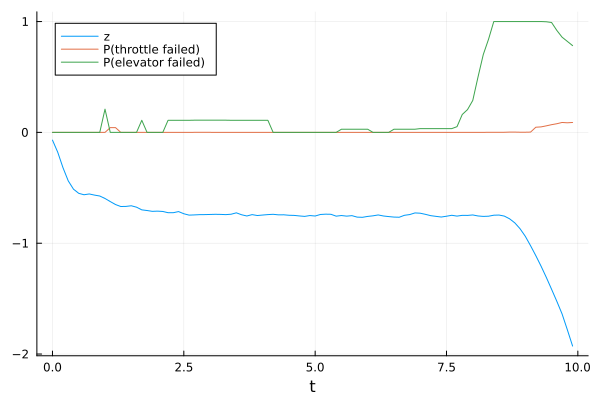

In [9]:
function particle_filter_rejuv_resim(num_particles::Int, observed::Matrix{Float64}, num_samples::Int)
    init_obs = Gen.choicemap((:obs0, observed[1, :]))
    state = Gen.initialize_particle_filter(flight_model_with_failure, (1,), init_obs, num_particles)

    T = size(observed, 1)
    for t=2:T
        # todo: rejuvenate entire trace, not just most recent failure estimate
        # apply a rejuvenation move to each particle
        @show t
#         for i=1:num_particles
#             window = 10
#             min_t = max(1, t - window)
#             move_choices = select(
#                 :x0,
#                 [:chain => t1 => :x_substeps => t2 => :d for t1=min_t:t-1 for t2=1:10]...,
#                 [:chain => t1 => :obs for t1=min_t:t-1]...,
#                 [:chain => t1 => :throttle_failure for t1=min_t:t-1]...,
#                 [:chain => t1 => :elevator_failure for t1=min_t:t-1]...,
#             )
#             state.traces[i], _  = mh(state.traces[i], move_choices)
#         end

        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        observations = Gen.choicemap((:chain => t => :obs, observed[t, :]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), observations)
    end

    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

N_particles = 2000
@time pf_rejuv_resim_traces = particle_filter_rejuv_resim(N_particles, observed, N_particles);
plot_consensus(observed, pf_rejuv_resim_traces)

In [10]:
T = size(observed, 1)
t = 1:T

N = length(pf_rejuv_resim_traces)
fig = plot()
for i=1:N
    fig = plot!(t, [pf_rejuv_resim_traces[i][:chain => ti => :state][2] for ti=1:T], label=nothing)
end
fig

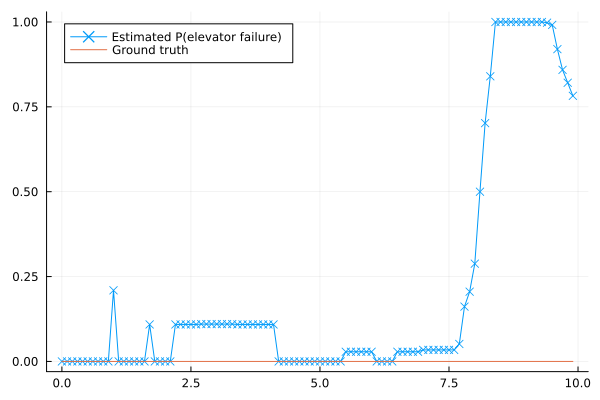

In [11]:
T = Gen.get_args(pf_rejuv_resim_traces[1])[1]
dt = 0.1
t_range = range(0.0, (T - 1) * dt, step=dt)

pt, pe = consensus(T, pf_rejuv_resim_traces)
plot(t_range, pe, marker=:x, label="Estimated P(elevator failure)", legend_position=:topleft)
plot!(t_range, [trace[:chain => t => :throttle_failure] for t=1:T], label="Ground truth")